## Instalação de Requisitos

In [ ]:
# Lendo o arquivo requisitos.txt
with open('requisitos.txt', 'r') as file:
    requirements = file.readlines()

# Removendo espaços em branco e quebras de linha
requirements = [requirement.strip() for requirement in requirements]

# Instalando as dependências usando pip
!pip3 install -U { ' '.join(requirements) }

## Importando o DataSet e Bibliotecas

link para o dataset: https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Configurando para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

#=========================================================|======================================================

file_path = 'NHANES_age_prediction.csv'
data = pd.read_csv(file_path, header=None)

# Deleta a primeira linha onde está as features
data = data.drop(data.index[0])

# Adiciona os nomes traduzidos ao data_set
names = ['id','grupo_idade','idade','genero','atividade_fisica','imc','glicose_pos_jejum','diabetes','saude_bucal','insulina']
data.columns = names

data.head()

,id,grupo_idade,idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
1,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
2,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
3,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
4,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
5,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


## Analisando o DATASET - Nauan

In [29]:
# 1. Dimensões do dataset
data.shape

(2278, 10)

In [30]:
# 2. Quantidade de valores NULOS(ou faltantes)
data.isnull().sum()

id                   0
grupo_idade          0
idade                0
genero               0
atividade_fisica     0
imc                  0
glicose_pos_jejum    0
diabetes             0
saude_bucal          0
insulina             0
dtype: int64

In [31]:
# 3. Valores únicos
for col in data.columns:
    print(f"\nColumn Name: {col}")
    print(data[col].value_counts())


Column Name: id
id
73564.0    1
80431.0    1
80408.0    1
80411.0    1
80417.0    1
          ..
76965.0    1
76964.0    1
76963.0    1
76958.0    1
83727.0    1
Name: count, Length: 2278, dtype: int64

Column Name: grupo_idade
grupo_idade
Adult     1914
Senior     364
Name: count, dtype: int64

Column Name: idade
idade
80.0    107
16.0     70
18.0     70
14.0     60
12.0     58
       ... 
76.0     13
75.0     12
77.0      9
79.0      8
78.0      8
Name: count, Length: 69, dtype: int64

Column Name: genero
genero
2.0    1165
1.0    1113
Name: count, dtype: int64

Column Name: atividade_fisica
atividade_fisica
2.0    1868
1.0     409
7.0       1
Name: count, dtype: int64

Column Name: imc
imc
23.9    26
23.7    24
27.4    22
25.8    22
24.2    21
        ..
44.8     1
63.0     1
39.7     1
17.8     1
48.0     1
Name: count, Length: 340, dtype: int64

Column Name: glicose_pos_jejum
glicose_pos_jejum
96.0     119
94.0     118
99.0     106
100.0    102
95.0      99
        ... 
175.0    

In [32]:
# 4. Estatísticas
# Converta todas as colunas para numéricas
dataDescribe = data.apply(pd.to_numeric, errors='coerce')

# Agora você pode usar describe()
dataDescribe.describe()

,id,grupo_idade,idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
count,2278.000000,0.0,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,NaN,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,NaN,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,NaN,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,NaN,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,NaN,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,NaN,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,NaN,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


## Pré-Processamento do DataSet - Nauan

In [33]:
# Removendo colunas desnecessárias
# Info importante: > 65 anos é considerado idoso e abaixo = Adulto
data = data.drop('id', axis=1)
data = data.drop('idade', axis=1)

# Transformando a feature grupo_idade(Nosso objetivo) em binário (ou numérico) [Adulto = 0, Idoso = 1]
data['grupo_idade'] = data['grupo_idade'].replace({'Adult': 0, 'Senior': 1})

# Garantindo que todos os dados estão realmente sendo tratados como numéricos
data = data.apply(pd.to_numeric, errors='coerce')

# Adicionar nome das colunas ao para a variável feature_names
data.feature_names = [data.columns]

# Substituindo o valor 7 encontrado como outlier acima por 2 na coluna 'atividade_fisica'
data['atividade_fisica'] = data['atividade_fisica'].replace(7, 2)

# Leitura dataset para verificar
data.head()

C:\Users\Nauan Aires\AppData\Local\Temp\ipykernel_9656\1191261002.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['grupo_idade'] = data['grupo_idade'].replace({'Adult': 0, 'Senior': 1})
C:\Users\Nauan Aires\AppData\Local\Temp\ipykernel_9656\1191261002.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.feature_names = [data.columns]


,grupo_idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
1,0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
2,0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
3,0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
4,0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
5,0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


Testando o melhor método para identificar outliers (no final não foi necessário)
1. método IQR (Interquartile Range)

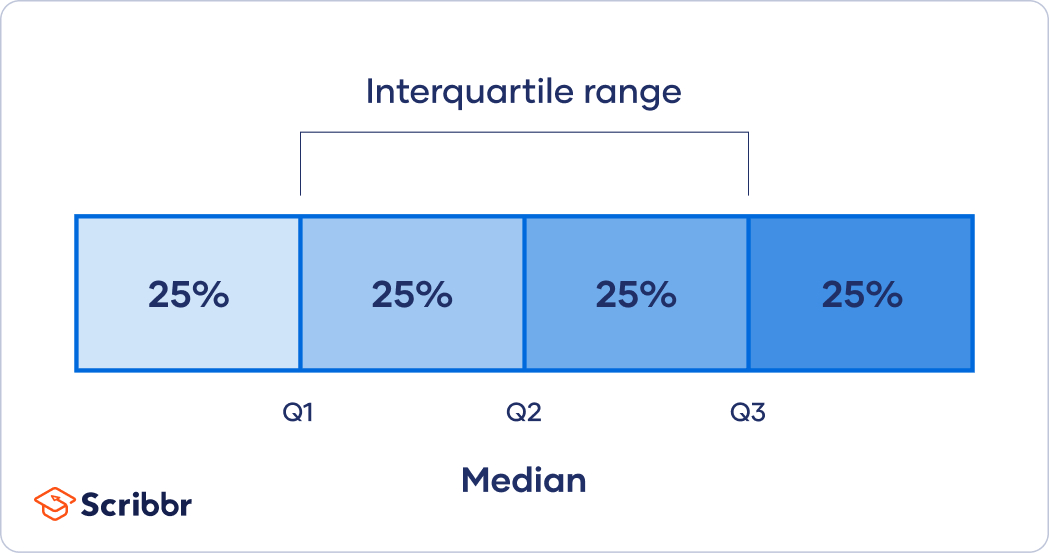

In [34]:
# Imagem com breve explicação sobre como funciona esse método para identificar outliers
from IPython.display import Image

# Caminho para a imagem
caminho_imagem = 'img/explicacaoIQR.jpg'

# Exibindo a imagem
Image(filename=caminho_imagem)

In [35]:
# Método IQR para identificar e tratar outliers

# Calcular Q1, Q3 e IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior para identificar outliers
lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR

# Identificar outliers
outliers = (data < lower_bound) | (data > upper_bound)

# Tratar os outliers (remover ou substituir)
data_tratada = data[~outliers.any(axis=1)]

# Exibir os outliers encontrados
print("Outliers identificados:")
print(data[outliers.any(axis=1)])

#Exibir os dados tratados (sem outliers)
print("\nDados tratados:")
print(data_tratada)

Outliers identificados:
      grupo_idade  genero  atividade_fisica   imc  glicose_pos_jejum  \
5               0     2.0               1.0  35.9              103.0   
9               1     1.0               2.0  38.9               89.0   
10              0     1.0               1.0  28.9               90.0   
12              0     2.0               1.0  27.3               85.0   
13              1     1.0               2.0  24.6              100.0   
...           ...     ...               ...   ...                ...   
2258            0     1.0               1.0  29.7               96.0   
2259            0     1.0               2.0  48.0               98.0   
2260            1     1.0               2.0  24.2              116.0   
2269            1     1.0               2.0  19.1               89.0   
2272            1     2.0               2.0  27.9              111.0   

      diabetes  saude_bucal  insulina  
5          2.0         81.0     10.92  
9          2.0        113.0    

2. Z-Score method

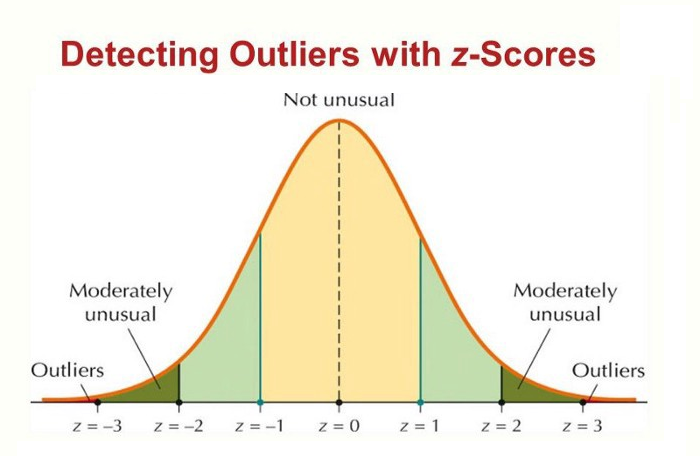

In [36]:
# Imagem com explicação sobre o método Z-Score para identificar e tratar outliers
from IPython.display import Image

# Caminho para a imagem
caminho_imagem = 'img/explicacaozscore.png'

# Exibindo a imagem
Image(filename=caminho_imagem)

In [19]:
# Teste de tratamento de dados com Z-Score
# Calcular o Z-score para cada ponto de dados
z_scores = stats.zscore(data)

# Determinar o limite de corte para identificar outliers (por exemplo, 3 desvios padrão)
# Threshhold = 13 apenas para identificar os outliers gritantes, mas o dataset não há necessidade de mudar tanta coisa até porque ele possui poucos dados
threshold = 6

# Identificar outliers
outliers = (abs(z_scores) > threshold).any(axis=1)

# Tratar os outliers (remover ou substituir)
data_tratada = data[~outliers]

# Exibir os outliers encontrados
print("Outliers identificados:")
print(data[outliers])

# Exibir os dados tratados (sem outliers)
print("\nDados tratados:")
print(data_tratada)

Outliers identificados:
      grupo_idade  genero  atividade_fisica   imc  glicose_pos_jejum  \
209             0     2.0               2.0  29.1              297.0   
213             1     1.0               2.0  44.6              208.0   
248             0     1.0               1.0  41.0               95.0   
610             0     2.0               2.0  29.0              250.0   
784             0     1.0               2.0  34.7               94.0   
819             0     2.0               2.0  28.6              257.0   
893             0     1.0               1.0  43.4              103.0   
953             0     1.0               2.0  37.3              275.0   
1069            0     2.0               2.0  34.0              210.0   
1116            0     1.0               2.0  30.4              223.0   
1225            0     1.0               2.0  27.6              405.0   
1548            0     1.0               2.0  31.4              368.0   
1660            0     1.0               

3. Comandos para testar se é utilizável ou não

In [37]:
data_tratada.describe()
#mean -> média dos valores na coluna
#std -> desvio padrão dos valores na coluna

,grupo_idade,genero,atividade_fisica,imc,glicose_pos_jejum,diabetes,saude_bucal,insulina
count,1444.0,1444.000000,1444.0,1444.000000,1444.00000,1444.0,1444.000000,1444.000000
mean,0.0,1.557479,2.0,27.203740,96.41482,2.0,106.000693,11.057590
std,0.0,0.496857,0.0,6.944825,9.68787,0.0,31.783561,7.193363
min,0.0,1.000000,2.0,14.500000,63.00000,2.0,41.000000,0.140000
25%,0.0,1.000000,2.0,22.000000,90.00000,2.0,84.000000,5.930000
50%,0.0,2.000000,2.0,26.200000,96.00000,2.0,100.000000,9.035000
75%,0.0,2.000000,2.0,30.800000,101.00000,2.0,123.000000,14.277500
max,0.0,2.000000,2.0,56.300000,140.00000,2.0,249.000000,39.660000


In [ ]:
# Se achar necessário a utilização do removedor de outliers execute o comando abaixo para substituir o dataset original
# data = data_tratada

## Dividindo o DataSet (Treino, Teste) - Nauan

In [6]:
# Separando nosso objetivo dos dados explicativos, sendo Y o target e X os dados explicativos
x = data.drop('grupo_idade', axis=1)
y = data['grupo_idade']

# Dividindo os dados em Treino e Teste (30% para teste)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

## Criando Máquina Preditiva
1. Algoritmo "Decision Tree" - Eduardo

In [63]:
# Algoritmo "Decision Tree"
maquina_preditiva = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10)
# OBS = Decision Tree acertou ~76.1% dos casos

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)

Accuracy_Dtree = maquina_preditiva.score(X_test, Y_test)

# Testando a máquina preditiva com dados de teste
Valor_predito = maquina_preditiva.predict(X_test)

# Exibindo as features e a previsão correspondente
for i in range(len(X_test)):
    print(f"Para {X_test.iloc[i].to_dict()}, a máquina preveu o grupo {Valor_predito[i]}")

# Exibindo a acurácia dos algoritmos
print(f"Acurácia: {Accuracy_Dtree:.2f} (DT)")

# Calculando o F1-Score
f1_dt = f1_score(Y_test, Valor_predito, average='weighted')

# Exibindo o F1-Score
print(f"F1-Score: {f1_dt:.2f}")

Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 19.3, 'glicose_pos_jejum': 87.0, 'diabetes': 2.0, 'saude_bucal': 53.0, 'insulina': 3.7}, a máquina preveu o grupo 0
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 22.5, 'glicose_pos_jejum': 100.0, 'diabetes': 2.0, 'saude_bucal': 100.0, 'insulina': 1.83}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.2, 'glicose_pos_jejum': 123.0, 'diabetes': 2.0, 'saude_bucal': 207.0, 'insulina': 19.78}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.4, 'glicose_pos_jejum': 223.0, 'diabetes': 1.0, 'saude_bucal': 256.0, 'insulina': 9.58}, a máquina preveu o grupo 1
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 32.6, 'glicose_pos_jejum': 92.0, 'diabetes': 2.0, 'saude_bucal': 116.0, 'insulina': 17.93}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 1.0, 'imc': 27.9, 'glicose_pos_jejum': 112.0, 'diabetes': 2.0, 'saude_bucal': 115.0, 'insulina': 18.7

2. Algoritmo "Random Forest" - Eduardo

In [64]:
# Algoritmo "Random Forest"

maquina_preditiva = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100)
# OBS = Random Forest acertou ~83.4% dos casos (melhor resultado)
# OBS.2 = Com o hiperparametro diferenes o resultado foi de ~85.25% de acerto (e se manteve em maioria dos casos testados)

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)

Accuracy_RForest = maquina_preditiva.score(X_test, Y_test)

# Testando a máquina preditiva com dados de teste
Valor_predito = maquina_preditiva.predict(X_test)

# Exibindo as features e a previsão correspondente
for i in range(len(X_test)):
    print(f"Para {X_test.iloc[i].to_dict()}, a máquina preveu o grupo {Valor_predito[i]}")

# Exibindo a acurácia dos algoritmos
print(f"Acurácia: {Accuracy_RForest:.2f} (RF)")

# Calculando o F1-Score
f1_rf = f1_score(Y_test, Valor_predito, average='weighted')

# Exibindo o F1-Score
print(f"F1-Score: {f1_rf:.2f}")

Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 19.3, 'glicose_pos_jejum': 87.0, 'diabetes': 2.0, 'saude_bucal': 53.0, 'insulina': 3.7}, a máquina preveu o grupo 0
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 22.5, 'glicose_pos_jejum': 100.0, 'diabetes': 2.0, 'saude_bucal': 100.0, 'insulina': 1.83}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.2, 'glicose_pos_jejum': 123.0, 'diabetes': 2.0, 'saude_bucal': 207.0, 'insulina': 19.78}, a máquina preveu o grupo 1
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.4, 'glicose_pos_jejum': 223.0, 'diabetes': 1.0, 'saude_bucal': 256.0, 'insulina': 9.58}, a máquina preveu o grupo 0
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 32.6, 'glicose_pos_jejum': 92.0, 'diabetes': 2.0, 'saude_bucal': 116.0, 'insulina': 17.93}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 1.0, 'imc': 27.9, 'glicose_pos_jejum': 112.0, 'diabetes': 2.0, 'saude_bucal': 115.0, 'insulina': 18.7

3. Algoritmo "k-nearest neighbors"

In [65]:

# Algoritmo "k-nearest neighbors"

maquina_preditiva = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights='uniform')
# OBS: O número de vizinhos (n_neighbors) pode ser ajustado para obter melhores resultados

# Treinando com os dados de treino
maquina_preditiva.fit(X_train, Y_train)

Accuracy_Knn = maquina_preditiva.score(X_test, Y_test)

# Testando a máquina preditiva com dados de teste
Valor_predito = maquina_preditiva.predict(X_test)

# Exibindo as features e a previsão correspondente
for i in range(len(X_test)):
    print(f"Para {X_test.iloc[i].to_dict()}, a máquina preveu o grupo {Valor_predito[i]}")

# Exibindo a acurácia dos algoritmos
print(f"Acurácia: {Accuracy_Knn:.2f} (KNN)")

# Calculando o F1-Score
f1_knn = f1_score(Y_test, Valor_predito, average='weighted')

# Exibindo o F1-Score
print(f"F1-Score: {f1_knn:.2f}")

Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 19.3, 'glicose_pos_jejum': 87.0, 'diabetes': 2.0, 'saude_bucal': 53.0, 'insulina': 3.7}, a máquina preveu o grupo 0
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 22.5, 'glicose_pos_jejum': 100.0, 'diabetes': 2.0, 'saude_bucal': 100.0, 'insulina': 1.83}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.2, 'glicose_pos_jejum': 123.0, 'diabetes': 2.0, 'saude_bucal': 207.0, 'insulina': 19.78}, a máquina preveu o grupo 1
Para {'genero': 1.0, 'atividade_fisica': 2.0, 'imc': 30.4, 'glicose_pos_jejum': 223.0, 'diabetes': 1.0, 'saude_bucal': 256.0, 'insulina': 9.58}, a máquina preveu o grupo 1
Para {'genero': 2.0, 'atividade_fisica': 2.0, 'imc': 32.6, 'glicose_pos_jejum': 92.0, 'diabetes': 2.0, 'saude_bucal': 116.0, 'insulina': 17.93}, a máquina preveu o grupo 0
Para {'genero': 1.0, 'atividade_fisica': 1.0, 'imc': 27.9, 'glicose_pos_jejum': 112.0, 'diabetes': 2.0, 'saude_bucal': 115.0, 'insulina': 18.7

## Avaliação da acurácia

1. Validação cruzada com K-Fold - Nauan

In [62]:
# Configuração da validação cruzada com k-Fold
k_fold = 5

# Algoritmos a serem avaliados
algoritmos = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10),
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100),
    'K-nearest neighbors': KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights='uniform')
}

# Avaliação dos algoritmos com validação cruzada
for nome, algoritmo in algoritmos.items():
    scores = cross_val_score(algoritmo, x, y, cv=k_fold)
    print(f"{nome}: Acurácia média = {scores.mean() * 100:.2f}% (+/- {scores.std() * 2 * 100:.2f}%)")

Decision Tree: Acurácia média = 79.32% (+/- 2.26%)
Random Forest: Acurácia média = 84.59% (+/- 0.77%)
K-nearest neighbors: Acurácia média = 83.27% (+/- 1.78%)


2. Testando melhores hiperparâmetros com Grid Search - Nauan

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definindo os modelos e os hiperparâmetros a serem testados
modelos = {
    'Decision Tree': {
        'modelo': DecisionTreeClassifier(),
        'parametros': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'modelo': RandomForestClassifier(),
        'parametros': {
            'n_estimators': [100, 200, 500, 1000],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'K-nearest neighbors': {
        'modelo': KNeighborsClassifier(),
        'parametros': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Realizando o Grid Search para cada modelo
resultados = []
for nome, config in modelos.items():
    grid_search = GridSearchCV(estimator=config['modelo'], param_grid=config['parametros'], cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, Y_train)
    resultados.append({
        'Modelo': nome,
        'Melhores Parâmetros': grid_search.best_params_,
        'Melhor Acurácia': grid_search.best_score_
    })

# Exibindo os resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[C

Visualização das features vs target em forma de gráfico - Nauan

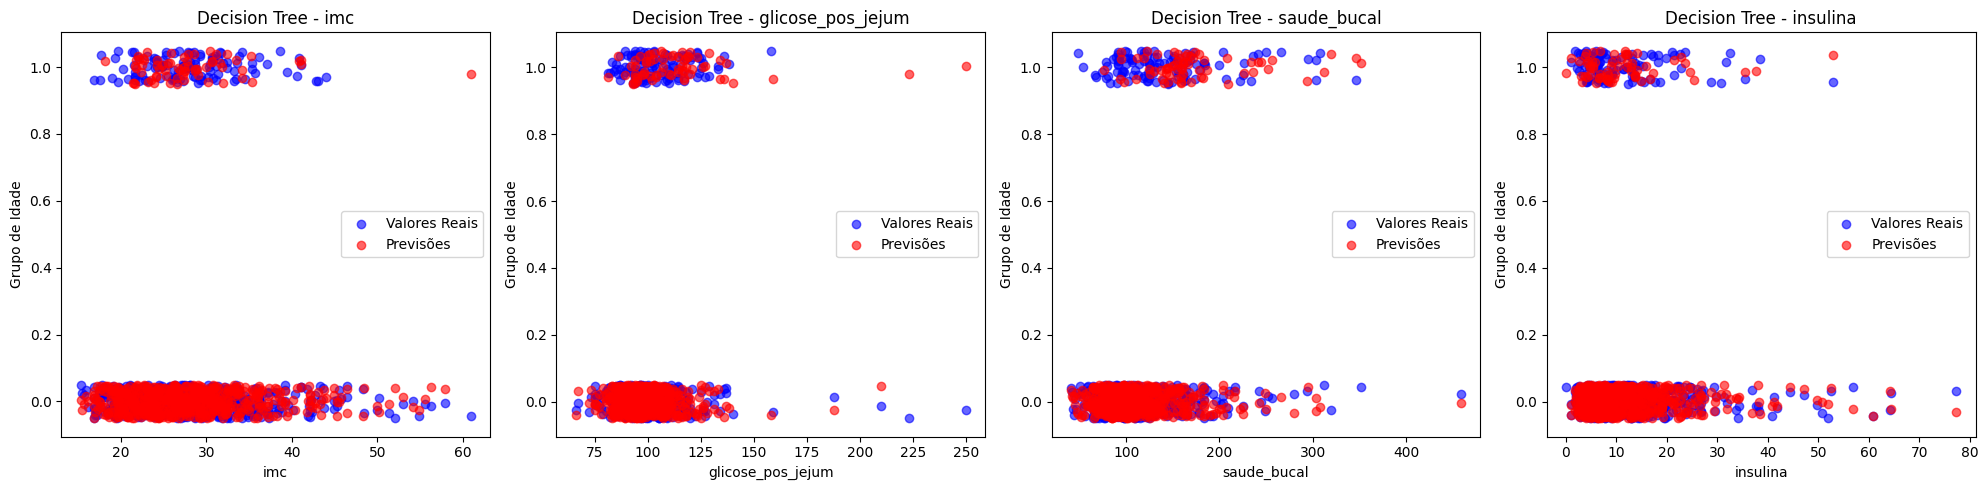

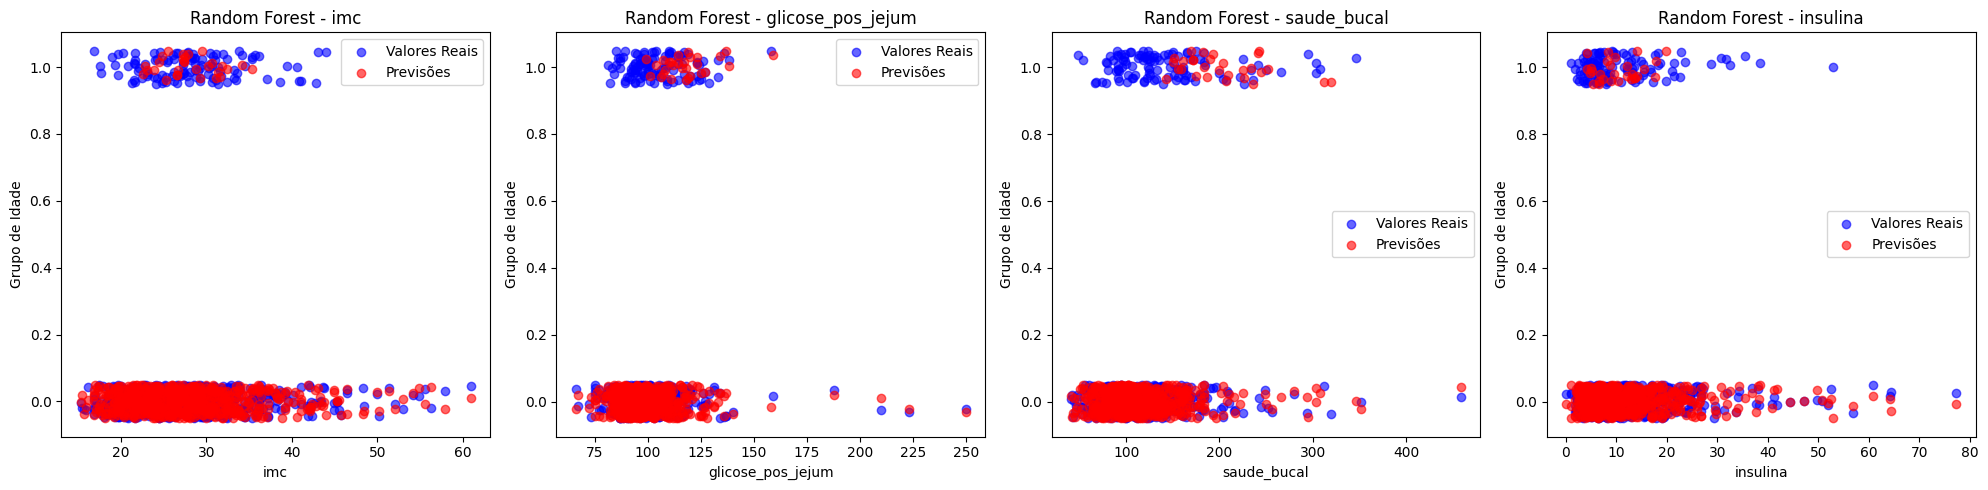

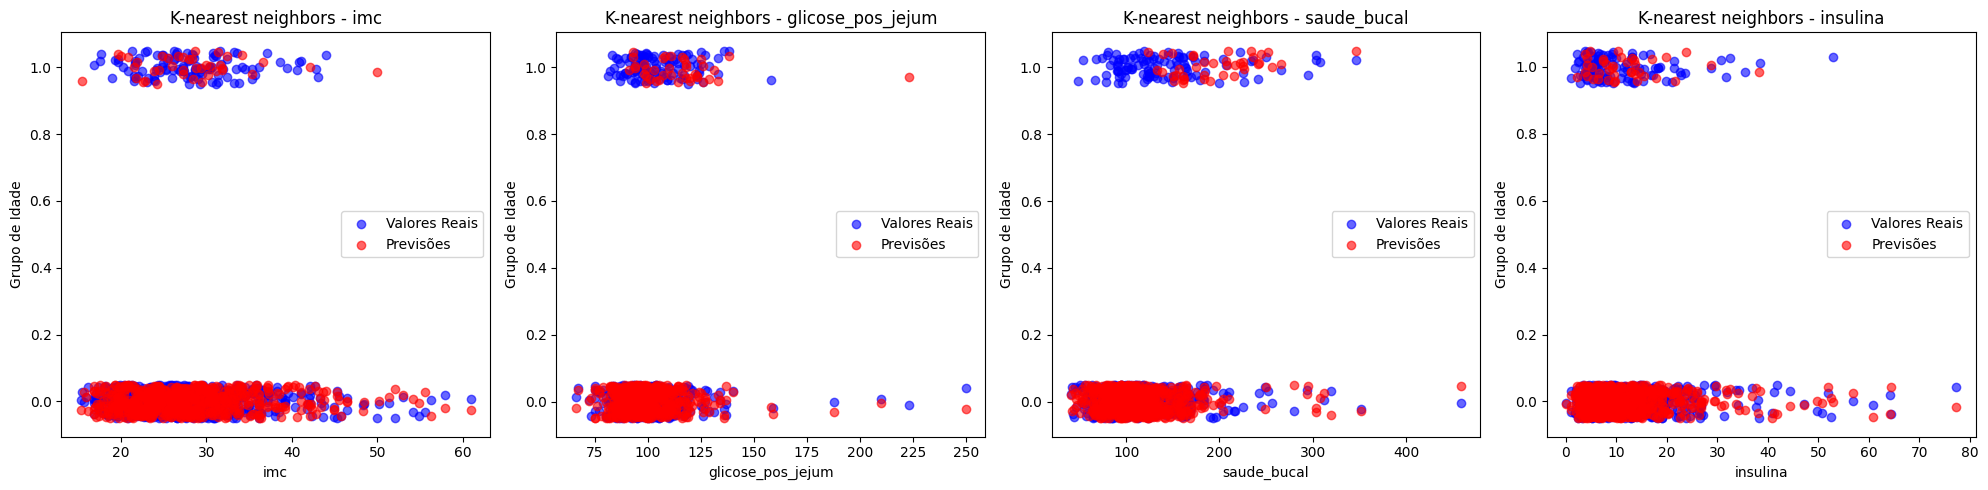

In [68]:
# Treinando os modelos com os melhores parâmetros encontrados pelo Grid Search
modelos = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10),
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100),
    'K-nearest neighbors': KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights='uniform')
}

# Selecionando algumas features para visualização
features_selecionadas = ['imc','glicose_pos_jejum','saude_bucal','insulina']

# Adicionando um pequeno ruído aos valores de Y para melhor visualização
def adicionar_ruido(y, nivel_ruido=0.05):
    return y + np.random.uniform(-nivel_ruido, nivel_ruido, size=len(y))

# Criando gráficos de dispersão para cada modelo e feature
for nome, modelo in modelos.items():
    modelo.fit(X_train, Y_train)
    predicoes = modelo.predict(X_test)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Ajuste o número de colunas conforme necessário
    for i, feature in enumerate(features_selecionadas[:4]):  # Ajuste o número de features conforme necessário
        axs[i].scatter(X_test[feature], adicionar_ruido(Y_test), color='blue', label='Valores Reais', alpha=0.6)
        axs[i].scatter(X_test[feature], adicionar_ruido(predicoes), color='red', label='Previsões', alpha=0.6)
        axs[i].set_title(f'{nome} - {feature}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Grupo de Idade')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()


## Apresentação de resultados através de gráficos e tabelas - Eduardo

                Método  Acurácia  F1-Score
0        Decision Tree  0.805556  0.784511
1        Random Forest  0.831871  0.790852
2  k-nearest neighbors  0.834795  0.800775


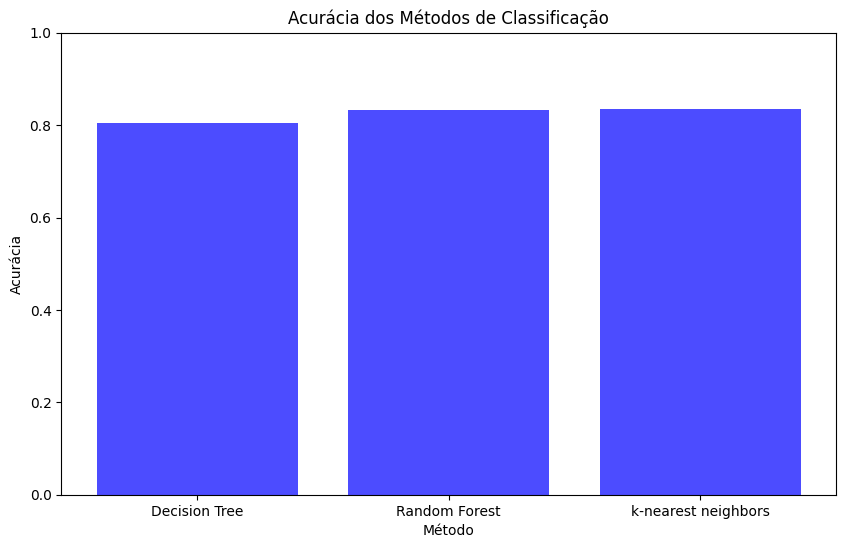

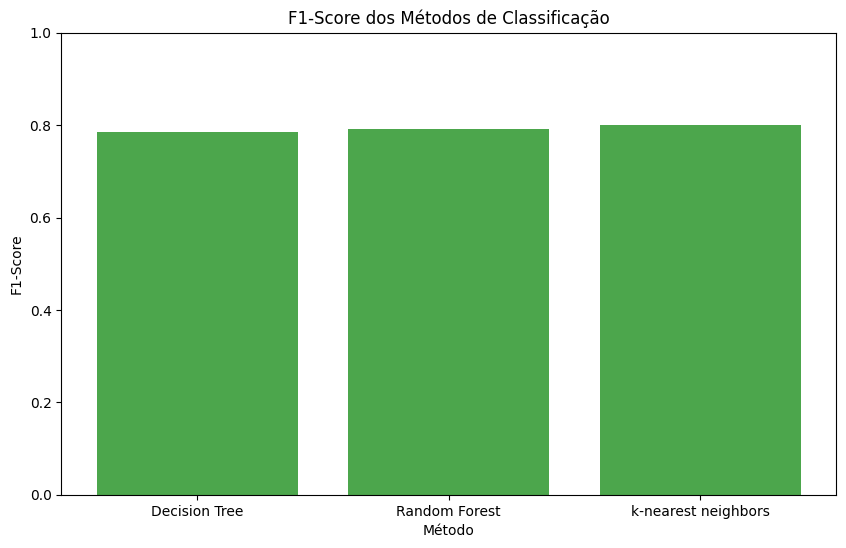

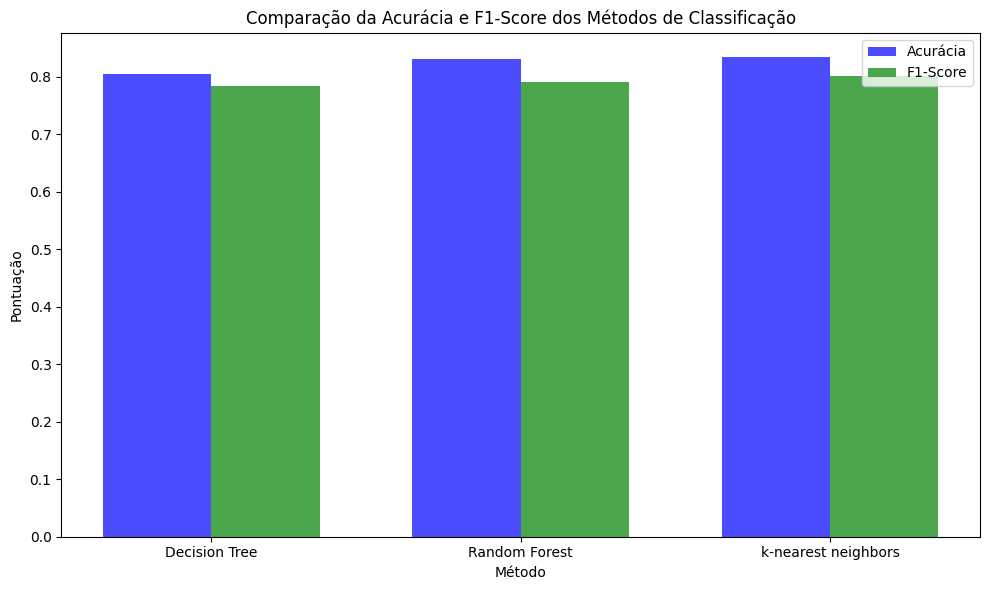

In [66]:
# Dados dos resultados
resultados = {
    'Método': ['Decision Tree', 'Random Forest', 'k-nearest neighbors'],
    'Acurácia': [Accuracy_Dtree, Accuracy_RForest, Accuracy_Knn],  # Exemplo de valores
    'F1-Score': [f1_dt, f1_rf, f1_knn]  # Exemplo de valores
}

# Criando um DataFrame para os resultados
df_resultados = pd.DataFrame(resultados)

# Exibindo a tabela de resultados
print(df_resultados)

# Gráfico de barras para a Acurácia
plt.figure(figsize=(10, 6))
plt.bar(df_resultados['Método'], df_resultados['Acurácia'], color='blue', alpha=0.7)
plt.title('Acurácia dos Métodos de Classificação')
plt.xlabel('Método')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()

# Gráfico de barras para o F1-Score
plt.figure(figsize=(10, 6))
plt.bar(df_resultados['Método'], df_resultados['F1-Score'], color='green', alpha=0.7)
plt.title('F1-Score dos Métodos de Classificação')
plt.xlabel('Método')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()

# Configurações para o gráfico de barras agrupadas
bar_width = 0.35
index = np.arange(len(df_resultados['Método']))

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, df_resultados['Acurácia'], bar_width, label='Acurácia', color='blue', alpha=0.7)
bar2 = plt.bar(index + bar_width, df_resultados['F1-Score'], bar_width, label='F1-Score', color='green', alpha=0.7)

# Adicionando detalhes ao gráfico
plt.xlabel('Método')
plt.ylabel('Pontuação')
plt.title('Comparação da Acurácia e F1-Score dos Métodos de Classificação')
plt.xticks(index + bar_width / 2, df_resultados['Método'])
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()